In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Define the Hindmarsh-Rose neuron model to simulate neuron dynamics
def hr_neuron_model(state, t, I, r):
    x, y, z = state
    dxdt = y + 3 * x**2 - x**3 - z + I  # Membrane potential dynamics
    dydt = 1 - 5 * x**2 - y  # Recovery variable dynamics
    dzdt = r * (4 * (x + 8/5) - z)  # Adaptation variable dynamics
    return [dxdt, dydt, dzdt]


In [2]:

# Define the Echo State Network class
class EchoStateNetwork:
    def __init__(self, N_res, p, alpha, rho):
        self.N_res = N_res  # number of neurons in the reservoir
        self.p = p  # connectivity probability
        self.alpha = alpha  # leaking rate of the reservoir
        self.rho = rho  # spectral radius
        self.Win = np.random.uniform(-0.5, 0.5, (N_res, 1))  # input weights
        self.Wres = self.initialize_reservoir(N_res, p, rho)  # reservoir weights
        self.Wout = None  # output weights to be learned

    # Initialize reservoir weights with specified sparsity and spectral radius
    def initialize_reservoir(self, N_res, p, rho):
        W = np.random.uniform(-1, 1, (N_res, N_res))
        mask = np.random.rand(N_res, N_res) < p
        W[~mask] = 0
        spectral_radius = np.max(np.abs(np.linalg.eigvals(W)))
        if spectral_radius > 0:
            W *= rho / spectral_radius
        else:
            print("Warning: Spectral radius is zero. Reservoir initialization might be faulty.")
        return W

    # Train the ESN using provided input and target output
    def train(self, u, y_target):
        states = np.zeros((len(u), self.N_res))
        state = np.zeros(self.N_res)
        for t in range(1, len(u)):
            state = (1 - self.alpha) * state + self.alpha * np.tanh(np.dot(self.Wres, state) + self.Win.flatten() * u[t])
            states[t] = state
        reg = Ridge(alpha=1e-6)
        reg.fit(states, y_target)
        self.Wout = reg.coef_

    # Generate predictions using the trained ESN
    def predict(self, u):
        states = np.zeros((len(u), self.N_res))
        state = np.zeros(self.N_res)
        y_pred = np.zeros(len(u))
        for t in range(1, len(u)):
            state = (1 - self.alpha) * state + self.alpha * np.tanh(np.dot(self.Wres, state) + self.Win.flatten() * u[t])
            states[t] = state
            y_pred[t] = np.dot(self.Wout, state)
        return y_pred


In [26]:

# Simulation and analysis parameters
initial_state = [-1.0, 2.0, 0.5]
dt = 0.02  # Time step for simulation
t = np.arange(0, 1500, dt)  # Time vector for simulation
r = 0.003  # Fixed parameter in the HR model
Tt = 40000  # Number of time steps to ignore in the transient

# Using optimized hyperparameters
optimized_params = optimized_params = {'N_res': 904, 'p': 0.8, 'alpha': 0.5, 'rho': 0.875}
N_warmup2 = 200000  # Second warm-up time

# Initialize the ESN with optimized parameters
esn_optimized = EchoStateNetwork(
    optimized_params['N_res'],
    optimized_params['p'],
    optimized_params['alpha'],
    optimized_params['rho']
)


In [28]:

# Function to compute interspike intervals (ISIs)
def compute_isis(time_series, threshold=1.0):
    spikes = np.where((time_series[:-1] < threshold) & (time_series[1:] >= threshold))[0]
    isis = np.diff(spikes) * dt
    return isis

# Vary control parameter I and analyze dynamics
I_values = np.arange(2.5, 3.5, 0.005)
log_isis_results = []


In [30]:

# Analyze each I value
for I in I_values:
    solution = odeint(hr_neuron_model, initial_state, t, args=(I, r))
    x = solution[:, 0]  # Extract membrane potential

    scaler = StandardScaler()
    x_normalized = scaler.fit_transform(x.reshape(-1, 1)).flatten()

    training_data = x_normalized[Tt:N_warmup2]
    esn_optimized.train(training_data[:-1], training_data[1:])
    predicted = esn_optimized.predict(training_data[:-1])
    predicted_denormalized = scaler.inverse_transform(predicted.reshape(-1, 1)).flatten()

    isis = compute_isis(predicted_denormalized)
    log_isis = np.log(isis) if len(isis) > 0 else [np.nan]

    log_isis_results.append(log_isis)


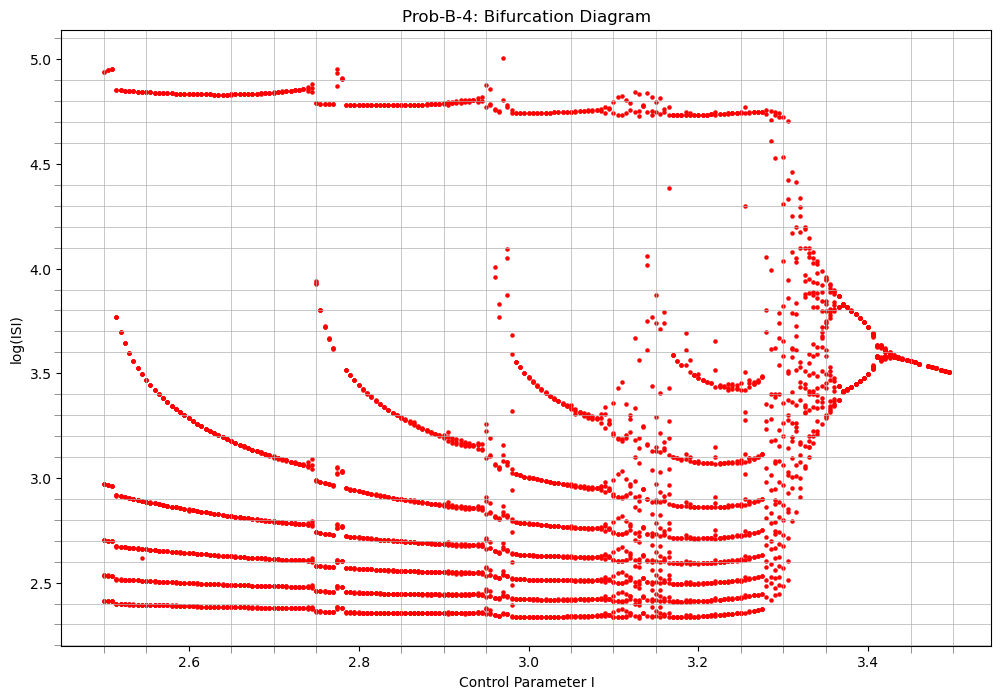

In [31]:
# Plot log(ISI) vs. Control Parameter I
plt.figure(figsize=(12, 8))
for i, I in enumerate(I_values):
    if len(log_isis_results[i]) > 0:
        plt.scatter([I] * len(log_isis_results[i]), log_isis_results[i], color='red', s=5)

plt.xlabel('Control Parameter I')
plt.ylabel('log(ISI)')
plt.title('Prob-B-4: Bifurcation Diagram')
plt.grid(True, which='minor', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.tick_params(which='minor', length=5, color='gray')
plt.savefig('Prob-B-4.png')  # Save the plot as a PNG file
plt.show()